In [2]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd
import scipy.stats as sc
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [3]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.head())
print(df_all_sorted.head())





astri_001_43_009_00002_R_201023_004_0201_SEB.lv0


astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1   
2  28859186       0  28859186   2217  263212       1   
3  32680807       0  32680807   4213  263212       1   
4  35023796       0  35023796    417  263213       1   

                                                  HG  \
0  [[2158, 2264, 2118, 2251, 2150, 2144, 2247, 22...   
1  [[2251, 2145, 2137, 2122, 2236, 2138, 2146, 22...   
2  [[2107, 2316, 2213, 2026, 2181, 2110, 2212, 21...   
3  [[2190, 2246, 2102, 2108, 2101, 2109, 2235, 

In [ ]:
dt = np.diff(df_all_sorted["TIME_ABS"])
logdt = np.log10(np.where(dt > 0, dt, 1e-12))

#per adesso cerco vicino il taglio queipochi eventi avvenuti simultaneamente ma diversi
mask =  (logdt < 3.2) 

df_dt = df_all_sorted.iloc[1:][mask]


#df_dt= df_all_sorted[ (np.log10(np.diff(df_all_sorted["TIME_ABS"]) < 3.2))]


#sono tanti, prendo i più energetici
df_dt['shape']= df_dt['HG'].apply(np.sum).to_numpy()
df_dt.sort_values('TIME_ABS',ascending=True, inplace=True)
df_dt.head()
print(df_dt["shape"].max())
print(df_dt["shape"].min())
df_dt = df_dt[df_dt["shape"] > 5280425 ]

print(len(df_dt))
print(len(df_dt))

5480425
5129820
20
20


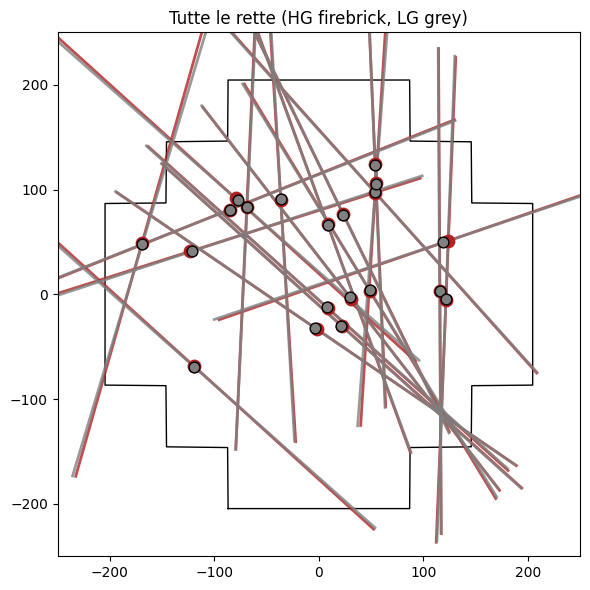

HG rette: 20
LG rette: 20
{'p0': array([-36.49597125,  90.39155262]), 'd': array([-0.06198727,  0.99807694]), 'tel': 1, 'mc_run': 263369, 'event': 9705}


In [20]:
#con sigma clip raccolgo rette, centroidi(senza stampare)
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T

x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

rette_hg = []
rette_lg = []

# ============================================================
#   calcolo, sigma clip, istogrammi, salvataggio rette

for iv in range(len(df_dt)):

    itel = df_dt["TEL_ID"].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]

    # mask di pixel buoni
    pxmask = (hgev > 2400) & (ttpev < 255)

    # --------------------------
    # SIGMA-CLIPPING
    
    xx = x_pix[pxmask].flatten()
    yy = y_pix[pxmask].flatten()
    w_hg = hgev[pxmask].flatten()
    w_lg = lgev[pxmask].flatten()

    mx0 = np.average(xx, weights=w_hg)
    my0 = np.average(yy, weights=w_hg)

    r = np.sqrt((xx - mx0)**2 + (yy - my0)**2)

    r_clip, low, high = sc.sigmaclip(r, low=3.0, high=3.0)
    keep = (r >= low) & (r <= high)

    xx_sc = xx[keep]
    yy_sc = yy[keep]
    w_hg_sc = w_hg[keep]
    w_lg_sc = w_lg[keep]
    # --------------------------

    # ---------- centroidi ----------
    meanx_hg = np.average(xx_sc, weights=w_hg_sc)
    meany_hg = np.average(yy_sc, weights=w_hg_sc)

    meanx_lg = np.average(xx_sc, weights=w_lg_sc)
    meany_lg = np.average(yy_sc, weights=w_lg_sc)

    # ---------- covarianze ----------
    cov_hg = np.cov([xx_sc, yy_sc], aweights=w_hg_sc)
    cov_lg = np.cov([xx_sc, yy_sc], aweights=w_lg_sc)

    # ---------- direzione ellisse ----------
    l1_hg = (cov_hg[0,0] + cov_hg[1,1])/2 + np.sqrt(((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2)
    l1_lg = (cov_lg[0,0] + cov_lg[1,1])/2 + np.sqrt(((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2)

    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    # ---------- salvo le rette ----------
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel,
        "mc_run": df_dt["MCRUN"].iloc[iv] ,
        "event": df_dt["EVENT"].iloc[iv]
    })

    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel,
        "mc_run": df_dt["MCRUN"].iloc[iv] ,
        "event": df_dt["EVENT"].iloc[iv]
    })


    

# ============================================================
#   tutte le rette insieme
xfp, yfp = at.utils.camera.get_xy_footprint()

fig, ax = plt.subplots(figsize=(6, 6))
# footprint camera 
ax.plot(xfp, yfp, 'k-', linewidth=1)

# calcolo lunghezza estetica delle rette
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag

# centroidi e rette HG
for r in rette_hg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide HG (punto rosso grande)
    ax.scatter(p0[0], p0[1], s=80, color="firebrick", zorder=5)

    # retta lunga HG (firebrick)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="firebrick", linewidth=2, alpha=0.8)

#  centroidi e rette LG 
for r in rette_lg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide LG (punto grigio più piccolo con bordo nero)
    ax.scatter(p0[0], p0[1], s=60, color="grey", edgecolor="black", zorder=5)

    # retta lunga LG (grey)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="grey", linewidth=2, alpha=0.8)

ax.set_title("Tutte le rette (HG firebrick, LG grey)")
ax.set_xlim(-250,250 )
ax.set_ylim(-250,250)

plt.tight_layout()
plt.show()

print("HG rette:", len(rette_hg))
print("LG rette:", len(rette_lg))
print(rette_hg[0])


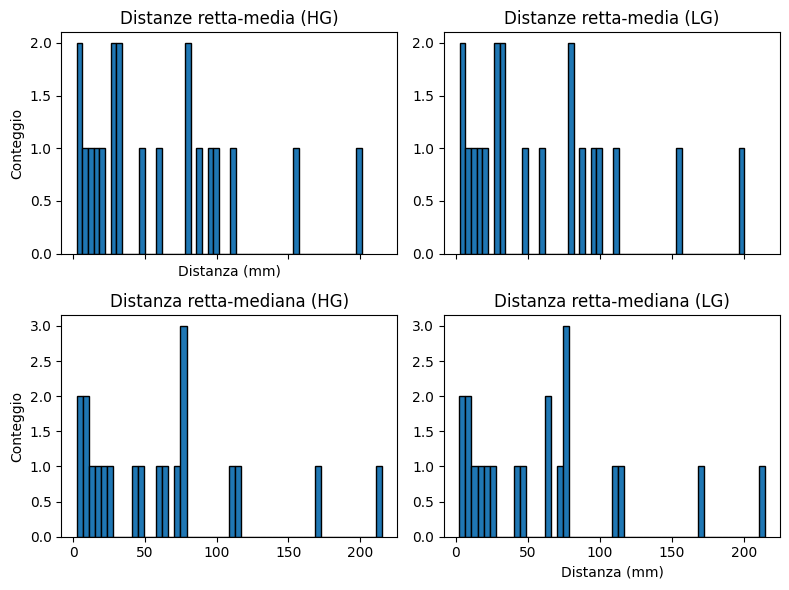

In [17]:
###   PROVA 1: distanza retta da media/mediana dell'intersezione
def intersection(p1, d1, p2, d2):
    """
    p1, p2 = centroidi
    d1, d2 = direzioni 
    """
    A = np.array([d1, -d2]).T
    b = p2 - p1

    # determinante per capire se sono parallele
    det = np.linalg.det(A)
    if abs(det) < 1e-6:
        return None  
    # risolvi i parametri t
    t = np.linalg.solve(A, b)[0]

    # punto di intersezione
    return p1 + t * d1
# ####################################################
# INTERSEZIONI TRA TUTTE LE COPPIE DI RETTE HG
# ####################################################
N = len(rette_hg)
inters_hg = []

for i in range(N):
    p1 = rette_hg[i]["p0"]
    d1 = rette_hg[i]["d"]
    for j in range(i+1, N):
        p2 = rette_hg[j]["p0"]
        d2 = rette_hg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_hg.append(P)

inters_hg = np.array(inters_hg)
v_hg_nf = inters_hg.copy()   


# #####################################################
# INTERSEZIONI TRA TUTTE LE COPPIE DI RETTE LG
N = len(rette_lg)
inters_lg = []

for i in range(N):
    p1 = rette_lg[i]["p0"]
    d1 = rette_lg[i]["d"]
    for j in range(i+1, N):
        p2 = rette_lg[j]["p0"]
        d2 = rette_lg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_lg.append(P)

inters_lg = np.array(inters_lg)
v_lg_nf = inters_lg.copy()  
#####Filtro i punti troppo lontani (grezzo)###############################################
v_hg= np.array([p for p in v_hg_nf if  all(-1000 <= coord <= 1000 for coord in p)])
v_lg= np.array([p for p in v_lg_nf if  all(-1000 <= coord <= 1000 for coord in p)])
###calcolo  media e mediana
centro_hg=np.mean(v_hg,axis=0)
centro_lg=np.mean(v_lg,axis=0)

median_hg=np.median(v_hg,axis=0)
median_lg=np.median(v_lg,axis=0)
### calcolo  distanze retta media/mediana
#HG
r_mean_hg = []
r_median_hg=[]
for r in rette_hg:

    p0 = r["p0"]
    d  = r["d"]  

    # normalizzazione
    norm_d = np.linalg.norm(d)
    if norm_d == 0:
        continue
    d_unit = d / norm_d

    # vettore da p0 al punto P
    v = centro_hg - p0
    u = median_hg - p0
    # distanza punto–retta
    dist_mean = abs(v[0] * d_unit[1] - v[1] * d_unit[0])
    dist_median=abs(u[0] * d_unit[1] - u[1] * d_unit[0])

    r_mean_hg.append(dist_mean)
    r_median_hg.append(dist_median)
r_mean_hg = np.array(r_mean_hg)
r_median_hg= np.array(r_median_hg)
#LG
r_mean_lg = []
r_median_lg=[]
for r in rette_lg:

    p0 = r["p0"]
    d  = r["d"]  

    # normalizzazione
    norm_d = np.linalg.norm(d)
    if norm_d == 0:
        continue
    d_unit = d / norm_d

    # vettore da p0 al punto P
    v = centro_hg - p0
    u = median_hg - p0
    # distanza punto–retta
    dist_mean = abs(v[0] * d_unit[1] - v[1] * d_unit[0])
    dist_median=abs(u[0] * d_unit[1] - u[1] * d_unit[0])

    r_mean_lg.append(dist_mean)
    r_median_lg.append(dist_median)
r_mean_lg = np.array(r_mean_lg)
r_median_lg= np.array(r_median_lg)
# -----------------------------
# Istogramma
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex='col')

# -------------------- HG --------------------
#  distanze tra coppie
axes[0,0].hist(r_mean_hg, bins=50, edgecolor='black')
axes[0,0].set_title("Distanze retta-media (HG)")
axes[0,0].set_ylabel("Conteggio")
axes[0,0].set_xlabel("Distanza (mm)")

#  distanze dal baricentro
axes[1,0].hist(r_median_hg, bins=50, edgecolor='black')
axes[1,0].set_title("Distanza retta-mediana (HG)")
axes[1,0].set_ylabel("Conteggio")



# -------------------- LG --------------------
#  distanze tra coppie
axes[0,1].hist(r_mean_lg, bins=50, edgecolor='black')
axes[0,1].set_title("Distanze retta-media (LG)")

#  distanze dal baricentro
axes[1,1].hist(r_median_lg, bins=50, edgecolor='black')
axes[1,1].set_title("Distanza retta-mediana (LG)")
axes[1,1].set_xlabel("Distanza (mm)")

plt.tight_layout()
plt.show()

